In [1]:
from explore_import import  *
import ionbot_preprocess as io
import data_preprocess as dt
import hpp_checker as hpp

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
global_folder="./../"
working_folder = "./../fromUGhent_v0114_3/combined-FDR/"
figsave_folder="./oui_discovery_subfigures/explore-1-group-wise-ionbot-open/"
wildcard="io_open"

In [3]:
#list my directory tree
dt.list_files(working_folder)

/
    canon-group-walk-input.csv
    openprot-group-walk-output.csv
    canon-group-walk-output.csv
    trembl-group-walk-input.csv
    openprot-group-walk-input.csv
    trembl-group-walk-output.csv
.ipynb_checkpoints/
    canon-group-walk-input-checkpoint.csv


In [18]:
combdb_cust=pd.DataFrame()
for file in glob.glob(f"{working_folder}*output*"):
    df=pd.read_csv(file,low_memory=False)
    database=file.split("/")[-1][:-len("-group-walk-output.csv")]
    df["searchDB"]=database
    combdb_cust=pd.concat([combdb_cust,df])

In [19]:
combdb_cust.columns

Index(['ionbot_match_id', 'spectrum_title', 'scan', 'spectrum_file',
       'precursor_mass', 'peptide_mass', 'observed_retention_time', 'charge',
       'database_peptide', 'matched_peptide', 'modifications',
       'unexpected_modification', 'database', 'psm_score', 'proteins',
       'experiment', 'leadprot', 'is.decoy', 'q.value', 'protein_classes',
       'isCanonical', 'isModified', 'custom_q', 'isTarget', 'FDRGroup',
       'group_qval', 'searchDB'],
      dtype='object')

In [20]:
combdb_cust[['searchDB']].value_counts()

searchDB
openprot    700138
trembl      679011
canon       664465
Name: count, dtype: int64

In [54]:
#compare how many spectra unfiltered, filtered by global, filtered by group-wise (custom) 

unfilt=combdb_cust[['spectrum_file','searchDB']]
glob_filt=combdb_cust[combdb_cust['q.value']<0.01]
cust_filt=combdb_cust[combdb_cust['custom_q']<0.01]

dfs = [unfilt,glob_filt,cust_filt]
labels=["unfilt","glob","cust"]
dfs = [pd.DataFrame(df[['spectrum_file','searchDB']].value_counts()).rename(columns={'count': f"count_{label}"}) 
       for label,df in zip(labels,dfs)]
comp_filt=dfs[0].join(dfs[1:])

In [55]:
comp_filt

count_unfilt  count_glob  count_cust
spectrum_file          searchDB                                      
AM12.mgf               openprot         24397       12435       12864
AM13.mgf               openprot         24337       11992       12380
AM8.mgf                openprot         24256        9910       10297
AM16.mgf               openprot         24169       13608       13991
AM12.mgf               trembl           23775       13035       13161
...                                       ...         ...         ...
ESC-HF-SampleHela3.mgf trembl           12406        7953        8077
                       canon            12319        8000        8129
ESC-HF-SampleHela4.mgf openprot         11877        6279        6556
                       trembl           11548        6705        6890
                       canon            11432        6752        6911

[108 rows x 3 columns]

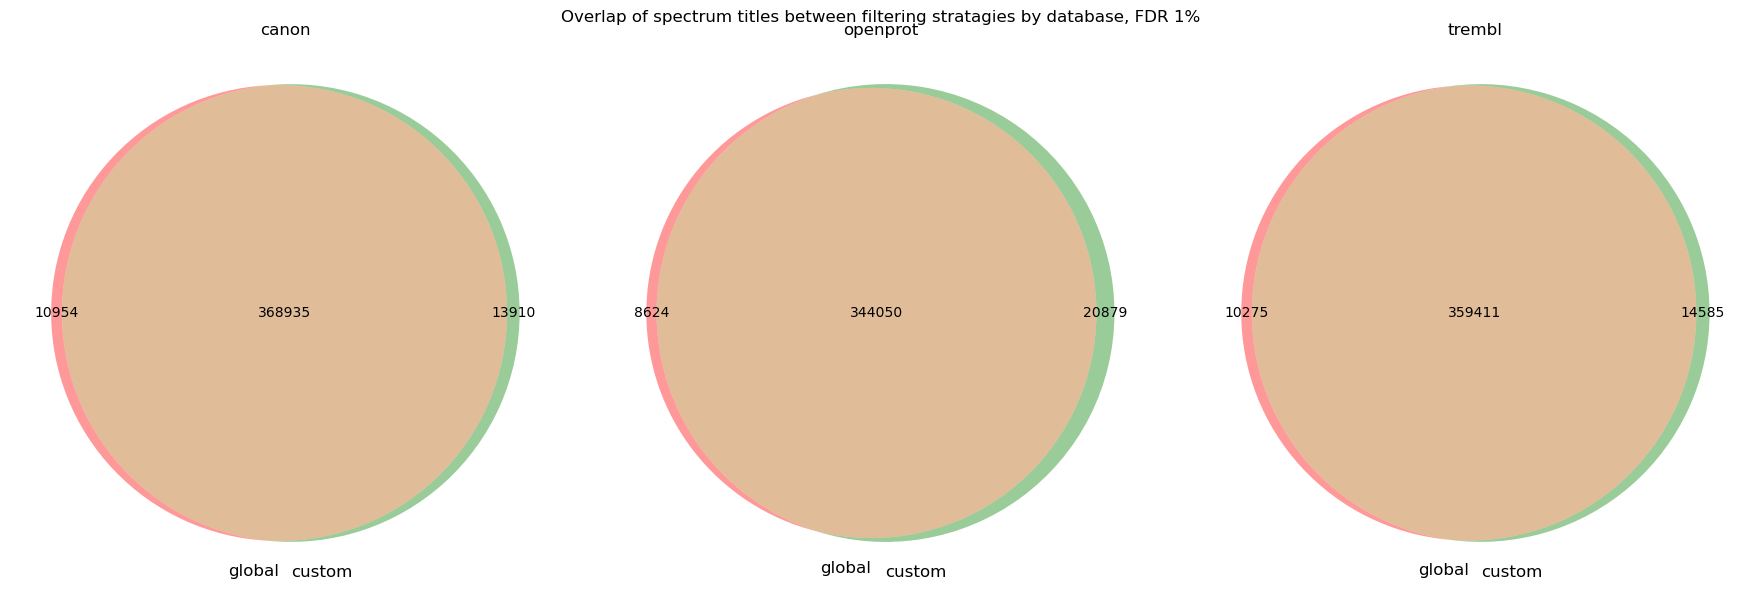

In [56]:
groups = list(combdb_cust.groupby("searchDB"))

fig, axes = plt.subplots(1, len(groups), figsize=(6 * len(groups), 6))
fig.suptitle("Overlap of spectrum titles between filtering stratagies by database, FDR 1%")

for ax, (searchDB, group) in zip(axes, groups):
    glob_filt = group[group['q.value'] < 0.01]
    cust_filt = group[group['custom_q'] < 0.01]
    venn2((set(glob_filt.spectrum_title), set(cust_filt.spectrum_title)), 
          set_labels=('global', 'custom'), ax=ax)
    ax.set_title(searchDB)

plt.tight_layout()
plt.show()


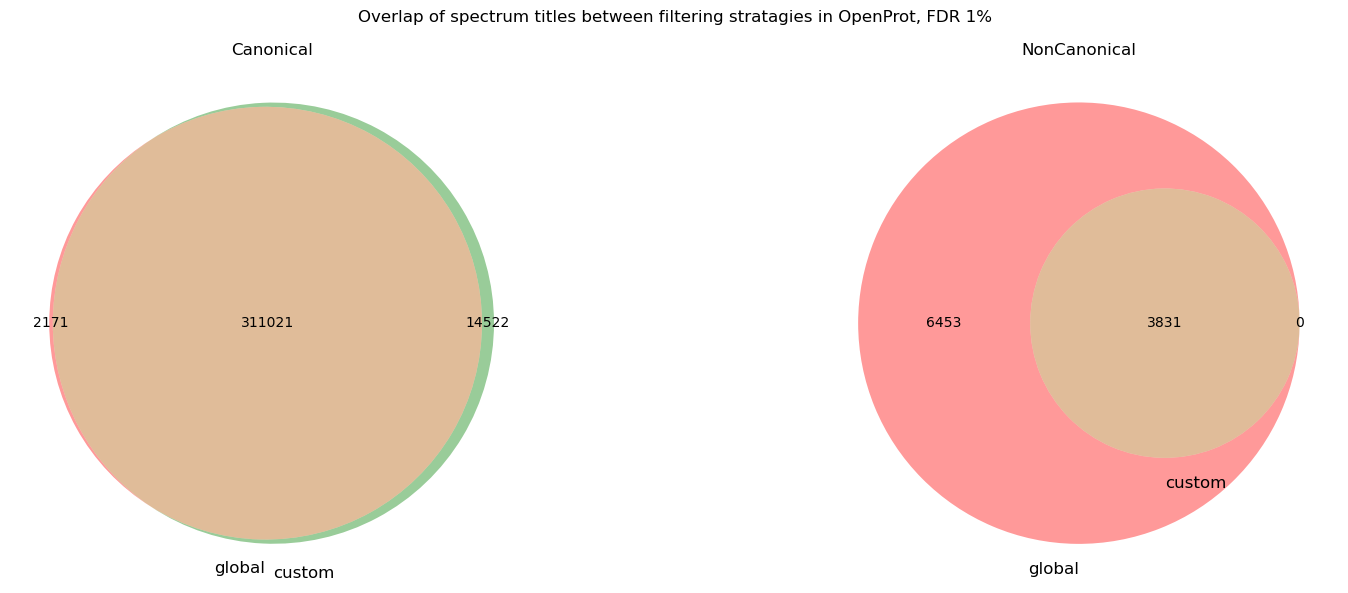

In [57]:
groups = combdb_cust[combdb_cust.searchDB=="openprot"].groupby("isCanonical")
group_names=["Canonical","NonCanonical"]

fig, axes = plt.subplots(1, len(group_names), figsize=(6 * len(groups), 6))
fig.suptitle("Overlap of spectrum titles between filtering stratagies in OpenProt, FDR 1%")

for ax, group_name in zip(axes, group_names):
    if group_name=="Contam": continue
    group=groups.get_group(group_name)
    glob_filt = group[group['q.value'] < 0.01]
    cust_filt = group[group['custom_q'] < 0.01]
    venn2((set(glob_filt.spectrum_title), set(cust_filt.spectrum_title)), 
          set_labels=('global', 'custom'), ax=ax)
    ax.set_title(group_name)

plt.tight_layout()
plt.show()

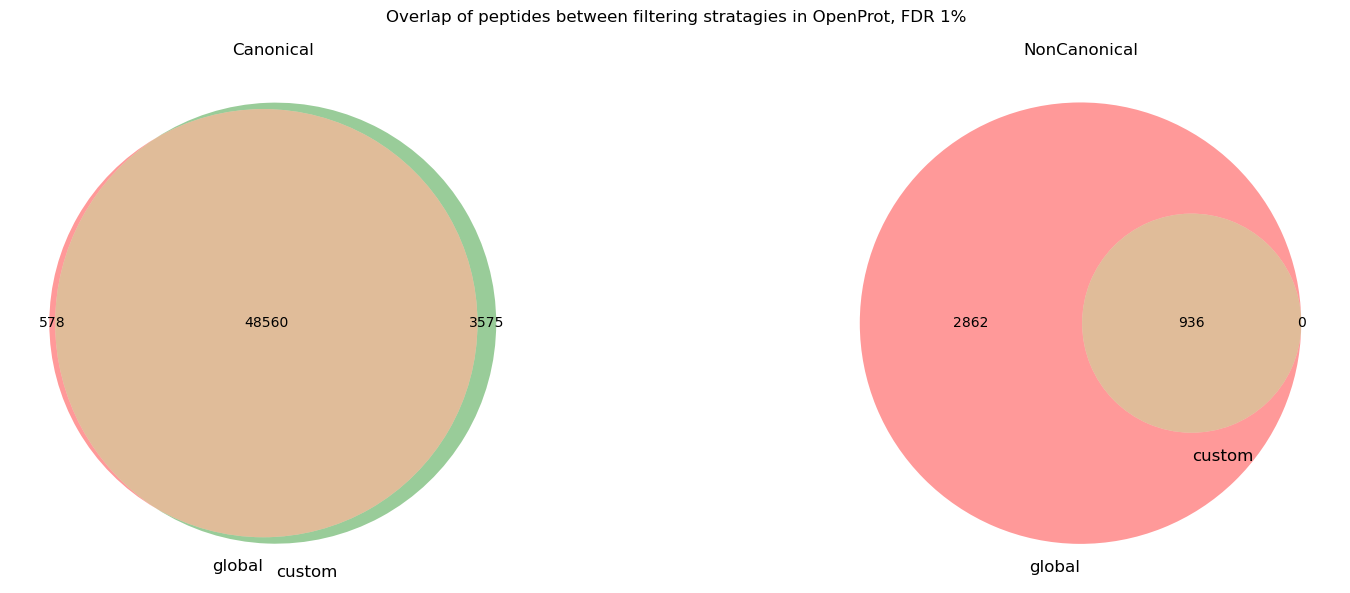

In [71]:
groups = combdb_cust[combdb_cust.searchDB=="openprot"].groupby("isCanonical")
group_names=["Canonical","NonCanonical"]

fig, axes = plt.subplots(1, len(group_names), figsize=(6 * len(groups), 6))
fig.suptitle("Overlap of peptides between filtering stratagies in OpenProt, FDR 1%")

for ax, group_name in zip(axes, group_names):
    if group_name=="Contam": continue
    group=groups.get_group(group_name)
    glob_filt = group[group['q.value'] < 0.01]
    cust_filt = group[group['custom_q'] < 0.01]
    venn2((set(glob_filt.database_peptide), set(cust_filt.database_peptide)), 
          set_labels=('global', 'custom'), ax=ax)
    ax.set_title(group_name)

plt.tight_layout()
plt.show()

In [76]:
(3575/(48560+3575))*100

6.857197659921358

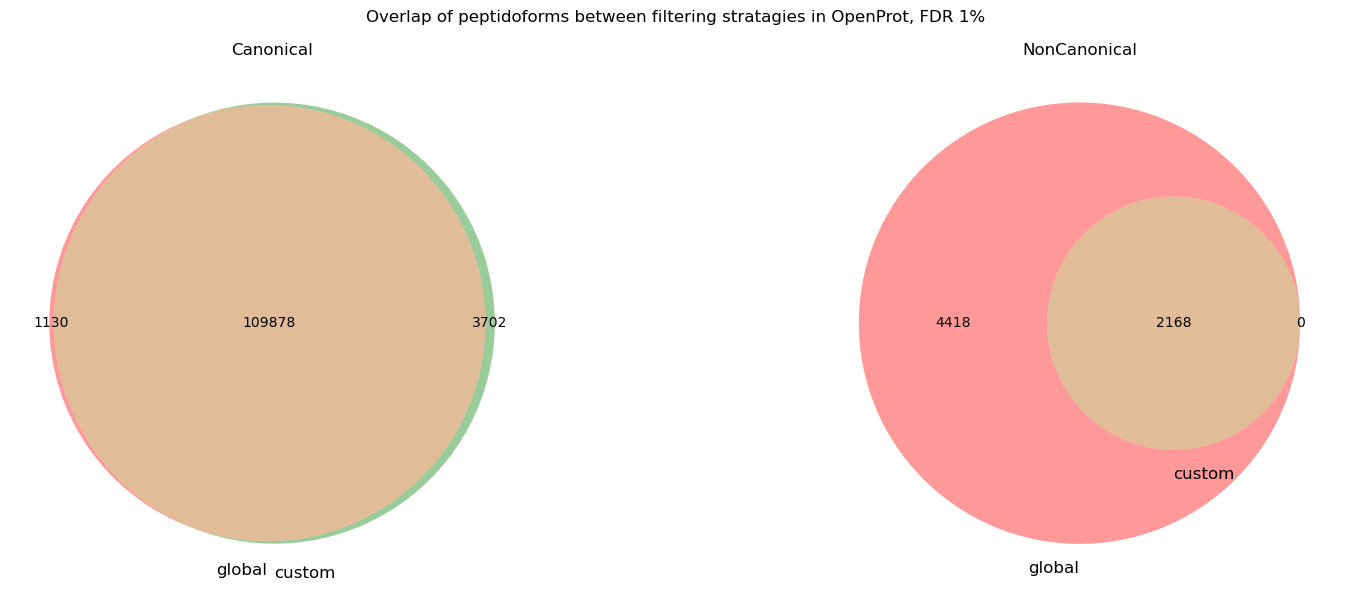

In [74]:
groups = combdb_cust[combdb_cust.searchDB=="openprot"].groupby("isCanonical")
group_names=["Canonical","NonCanonical"]

fig, axes = plt.subplots(1, len(group_names), figsize=(6 * len(groups), 6))
fig.suptitle("Overlap of peptidoforms between filtering stratagies in OpenProt, FDR 1%")

for ax, group_name in zip(axes, group_names):
    if group_name=="Contam": continue
    group=groups.get_group(group_name)
    glob_filt = group[group['q.value'] < 0.01]
    cust_filt = group[group['custom_q'] < 0.01]
    venn2((set(glob_filt.database_peptide+glob_filt.modifications), set(cust_filt.database_peptide+cust_filt.modifications)), 
          set_labels=('global', 'custom'), ax=ax)
    ax.set_title(group_name)

plt.tight_layout()
plt.show()

In [62]:
#what global q-value threshold corresponds to custom 1%
combdb_cust[(combdb_cust.searchDB=="openprot")&(combdb_cust['custom_q'] < 0.01)&(combdb_cust.database=="T")].groupby("isCanonical")['q.value'].max()

isCanonical
Canonical       0.036302
Contam          0.337569
NonCanonical    0.000573
Name: q.value, dtype: float64

In [63]:
def classify_peptide_io(row,mode):    
    if any('decoy' in i for i in row):
        return 'Decoy'        
    
    if any('CONTAMINANT' in x or 'contaminant' in x for x in row):
        return 'Contam'
    elif all(x.startswith('II_') or x.startswith('IP_') for x in row):
        if len(row)==1: 
            return "unique_to_Noncanon"
        else:
            return 'shared_in_Noncanon'
    elif all(not x.startswith('II_') and not x.startswith('IP_') and not 'CONTAMINANT' in x and not 'contaminant' in x for x in row):
        if len(row)==1: 
            return "unique_to_Canon"
        else:
            return 'shared_in_Canon'
    else:
        return 'shared_btw_can_noncan'

In [64]:
combdb_cust["peptide_class"]=combdb_cust.proteins.apply(lambda x: classify_peptide_io(x.split(";"),"closed"))

In [68]:
#overlap
glob_filt=combdb_cust[(combdb_cust.searchDB=="openprot")&(combdb_cust['q.value'] < 0.01)]["peptide_class"].value_counts()
comb_filt=combdb_cust[(combdb_cust.searchDB=="openprot")&(combdb_cust['q.value'] < 0.01)&(combdb_cust['custom_q'] < 0.01)]["peptide_class"].value_counts()
comb_filt/glob_filt

peptide_class
shared_btw_can_noncan    0.994045
shared_in_Canon          0.994202
Contam                   1.000000
unique_to_Canon          0.973591
unique_to_Noncanon       0.364578
shared_in_Noncanon       0.453653
Name: count, dtype: float64